# Calculating travel time to ID registration sites in Liberia

As part of a project supporting a national ID system in Liberia we are calculating travel time to physical ID sites.

The country has limited financial capacity, so they are looking for as efficient a solution as possible. At the same time, there needs to be a focus on equality - we cannot miss just the people who are hard to reach

Goal is to prioritize investment in existing licensing centers, and provide some metrics to identify which proposed centers should be supported:
## Existing licensing centers
1.	How many people within 60 mins and 120 mins drive time  
    a. Summarize at ADM1 and ADM2
2.	How many exclusive users within 120 mins drive time (Marketsheds)
3.	ADM1 and ADM2 summaries of population outside 120 min drive time of existing centers  
    a. This population layer is labelled “unserved population” and used for several analyses below
## Proposed centers
1.	Total # of people within 60, 120 min vectors  
    a. Replicate using the population layer from #3 above, which is the unserved population
2.	Marketsheds  
    a. Replicate using unserved population layer
3.	Prioritize proposed centers sequentially using the results of #1 and #2 to identify how to serve the most population with the fewest centers


In [1]:
import sys, os, json
import rasterio, overturemaps

import pandas as pd
import geopandas as gpd
import numpy as np
import skimage.graph as graph

from shapely.geometry import Point, box
#from space2stats_client import Space2StatsClient

### TODO: Update GOSTrocks and GOSTnetsraster imports to use package structure
sys.path.insert(0, r"C:\WBG\Work\Code\GOSTrocks\src")
import GOSTrocks.rasterMisc as rMisc
import GOSTrocks.dataMisc as dMisc
import GOSTrocks.ntlMisc as ntlMisc
import GOSTrocks.mapMisc as mapMisc
from GOSTrocks.misc import tPrint
sys.path.append(r"C:\WBG\Work\Code\GOSTnetsraster\src")
import GOSTnetsraster.market_access as ma
import GOSTnetsraster.conversion_tables as speed_tables

%load_ext autoreload
%autoreload 2

GDAL is not installed - OGR functionality not available


In [2]:
# Input parameters
m_crs = "ESRI:54009" # Need to project data to a metres-based projection
ISO3 = "LBR"

# Define input data
base_folder = "C:/WBG/Work/Projects/LBR_Road_Improvements"
for c_folder in [os.path.join(base_folder, "DATA"), os.path.join(base_folder, "RESULTS")]:
    if not os.path.exists(c_folder):
        os.makedirs(c_folder)
landcover_file = os.path.join(base_folder, "DATA", 'ESA_Globcover.tif')
# These are the digitized road segements that have been improved

transport_network = os.path.join(base_folder, "DATA", "Overture", "transport_network.gpkg")
major_roads_file = os.path.join(base_folder, "DATA", "Overture", "major_roads.gpkg")
fixed_id_sites_file = os.path.join(base_folder, "DATA", "LBR_ID_sites.kmz")
proposed_id_sites_file = os.path.join(base_folder, "DATA", "Enrollment_Locations_phase1_tentative.csv")

# WorldPop 2020 constrained, projected to m_crs
pop_file = os.path.join(base_folder, "DATA", "lbr_pop_2025_CN_1km_R2025A_UA_v1.tif")
pop_file_synced = os.path.join(base_folder, "DATA", "lbr_pop_2025_CN_1km_R2025A_UA_v1_synced.tif")

# administrative bounadaries are used to summarize population
global_adm2_file =  r"C:\WBG\Work\data\ADMIN\NEW_WB_BOUNDS\FOR_PUBLICATION\geojson\WB_GAD_ADM2.geojson"
adm2 = gpd.read_file(global_adm2_file)
adm2 = adm2.loc[adm2['ISO_A3'] == ISO3]

global_adm0_file =  r"C:\WBG\Work\data\ADMIN\NEW_WB_BOUNDS\FOR_PUBLICATION\geojson\WB_GAD_ADM0.geojson"
adm0 = gpd.read_file(global_adm0_file)

# Define output files
friction_folder = os.path.join(base_folder, "DATA", "FRICTION")
results_folder = os.path.join(base_folder, "RESULTS")
overture_folder = os.path.join(base_folder, "DATA", "Overture")
for cFolder in [friction_folder, results_folder, overture_folder]:
    if not os.path.exists(cFolder):
        os.makedirs(cFolder)    

friction_file = os.path.join(friction_folder, 'GLOBAL_FRICTION_{}.tif'.format(ISO3))
friction_file_proj = os.path.join(friction_folder, 'GLOBAL_FRICTION_{}_proj.tif'.format(ISO3))

In [3]:
# Download roads from Overture
#Download transport network
if not os.path.exists(transport_network):    
    bbox = adm2.total_bounds.tolist()  # minx, miny, maxx, maxy
    transport = overturemaps.record_batch_reader("segment", bbox).read_all()
    transport_df = gpd.GeoDataFrame.from_arrow(transport)
    transport_df.crs = 4326
    transport_df.loc[:, ["id", "class", "subtype", "road_surface", "speed_limits", "width_rules", "geometry"]].to_file(transport_network, driver="GPKG")

# process transport to a) remove roads outside IRAQ and b) remove all roads of OSMLR class 3 and 4
if not os.path.exists(major_roads_file):
    roads = gpd.read_file(transport_network)
    roads['OSMLR_class'] = roads['class'].map(speed_tables.OSMLR_Classes)
    roads_joined = gpd.sjoin(roads, adm2, how="inner", predicate="intersects")
    major_roads = roads_joined.loc[roads_joined['OSMLR_class'].isin(['OSMLR level 1', 'OSMLR level 2']), roads.columns]
    major_roads.to_file(major_roads_file, driver="GPKG", index=False)

In [4]:
# Extract friction surface for country
if not os.path.exists(friction_file_proj):
    global_friction_file = r"C:\WBG\Work\data\FRICTION\2020_motorized_friction_surface.geotiff"
    rMisc.clipRaster(rasterio.open(global_friction_file), adm2.to_crs(rasterio.open(global_friction_file).crs), friction_file, crop=False)
    rMisc.project_raster(rasterio.open(friction_file), m_crs, friction_file_proj)

# Sync the population raster to the friction layer
if not os.path.exists(pop_file_synced):
    rMisc.standardizeInputRasters(rasterio.open(pop_file), rasterio.open(friction_file_proj), pop_file_synced, resampling_type='sum')
    

# Map road network and service centers

In [5]:
major_roads = gpd.read_file(major_roads_file)
major_roads['map_class'] = major_roads['OSMLR_class'].apply(lambda x: 5-int(x[-1]))
lbr_country = adm0.loc[adm0['ISO_A3'] == 'LBR']
other_countries = adm0.loc[adm0['ISO_A3'] != 'LBR']

In [6]:
proposed_sites = pd.read_csv(proposed_id_sites_file)
proposed_sites['geometry'] = proposed_sites.apply(lambda row: Point(row['X_UTM'], row['Y_UTM']), axis=1)
proposed_sites = gpd.GeoDataFrame(proposed_sites, geometry='geometry', crs=10802)
proposed_sites = proposed_sites.to_crs(major_roads.crs)

existing_sites = gpd.read_file(fixed_id_sites_file, driver='KML')
existing_sites = existing_sites.to_crs(major_roads.crs)


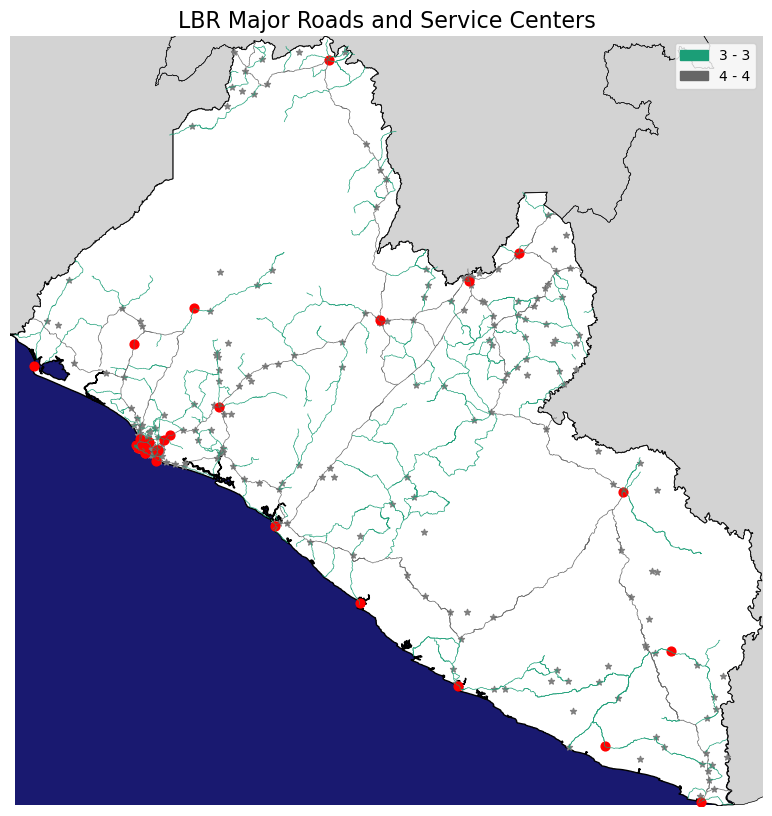

In [7]:
plt, fig, ax = mapMisc.static_map_vector(major_roads, "map_class", colormap='Dark2', add_basemap=False, add_wb_borders_lines=False)

lbr_country.plot(ax=ax, facecolor="white", edgecolor="black", linewidth=1, zorder=0)
other_countries.plot(ax=ax, facecolor="lightgrey", edgecolor="black", linewidth=0.5, zorder=1)
proposed_sites.plot(ax=ax, color='grey', markersize=20, marker="*")
existing_sites.plot(ax=ax, color='red', markersize=40, marker="o")
bbox = lbr_country.total_bounds
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])
ax = ax.set_axis_off()
plt.title("LBR Major Roads and Service Centers", fontsize=16)
plt.savefig("maps/LBR_existing_and_proposed_service_centers.png", dpi=300, bbox_inches='tight')
plt.show()

## Calculate travel time to ID registration sites

In [8]:
in_pop = rasterio.open(pop_file_synced)
pre_friction = rasterio.open(friction_file_proj)
# Calculate pre-intervention, population-weighted travel times summarized at admin 2
frictionD = pre_friction.read()[0,:,:]
frictionD = frictionD * pre_friction.res[0]
mcp = graph.MCP_Geometric(frictionD)

drive_time_thresholds = [30, 60, 120, 180, 240] # minutes

for dest, label in [
    (existing_sites, "existing_ID"),
    (proposed_sites, "proposed_ID")
    ]:
    dest = dest.to_crs(pre_friction.crs)

    tt_file = os.path.join(results_folder, f"Travel_time_to_{label}.tif")
    tt_dest = ma.summarize_travel_time_populations(in_pop, pre_friction, dest, mcp, adm2, 
                                                        out_tt_file=tt_file)
    
    drive_vectors = ma.generate_feature_vectors(pre_friction, mcp, dest, drive_time_thresholds)

    # Summarize population within drive time thresholds
    dt_pop_summary = rMisc.zonalStats(drive_vectors, in_pop, return_df=True, minVal=0)
    dt_pop_summary['tempID'] = drive_vectors['IDX']
    dt_pop_summary['threshold'] = drive_vectors['threshold']

    population_summaries = pd.pivot_table(dt_pop_summary, values='SUM', index=['tempID'], columns=['threshold'], aggfunc='sum').reset_index()
    summarized_population_drivetime = pd.merge(dest, population_summaries, on='tempID')

    # Generate marketsheds and summarize population within each marketshed
    market_sheds = ma.generate_market_sheds(pre_friction, dest, column_id='tempID')
    pop_data = in_pop.read()[0,:,:]
    unq_dests = np.unique(market_sheds)
    tt_data = rasterio.open(tt_file).read()[0,:,:]

    out_res = {}
    for c_dest in unq_dests:
        dest_mask = market_sheds == c_dest
        dest_pop_sum = pop_data[dest_mask].sum()
        dest_pop_120min = pop_data[(dest_mask) & (tt_data <= 120)].sum()
        out_res[c_dest] = {'total_pop': dest_pop_sum, 'pop_120min': dest_pop_120min, 'n_pixels': dest_mask.sum() }

    res = pd.DataFrame(out_res).T
    res['tempID'] = res.index
    final_marketsheds = pd.merge(dest, res, on='tempID')
    final_marketsheds.drop(['geometry', 'tempID'], axis=1).to_csv(os.path.join(results_folder, f"Marketshed_population_{label}.csv"))

    # Write geospatial data to file
    tt_dest.to_file(os.path.join(results_folder, f"ADM2_tt_{label}.gpkg"), driver="GPKG")
    drive_vectors.to_file(os.path.join(results_folder, f"Drive_time_vectors_{label}.gpkg"), driver="GPKG")
    with rasterio.open(os.path.join(results_folder, f"Marketsheds_{label}.tif"), 'w', **in_pop.meta) as out_raster:
        out_raster.write(market_sheds, 1)
    
    # Write tabular data to file
    pd.DataFrame(tt_dest.drop(["geometry"], axis=1)).to_csv(os.path.join(results_folder, f"ADM2_tt_{label}.csv"))
    summarized_population_drivetime.drop(['geometry', 'tempID'], axis=1).to_csv(os.path.join(results_folder, f"Population_within_drivetime_{label}.csv"))


C:\WBG\Work\Code\GOSTnetsraster\src\GOSTnetsraster\market_access.py:480: RuntimeWarning: invalid value encountered in multiply
  tt_pop = ttD * popD


10:41:45	1 of 30: 0
10:41:46	2 of 30: 1
10:41:46	3 of 30: 2
10:41:46	4 of 30: 3
10:41:46	5 of 30: 4
10:41:46	6 of 30: 5
10:41:46	7 of 30: 6
10:41:46	8 of 30: 7
10:41:46	9 of 30: 8
10:41:47	10 of 30: 9
10:41:47	11 of 30: 10
10:41:47	12 of 30: 11
10:41:47	13 of 30: 12
10:41:47	14 of 30: 13
10:41:47	15 of 30: 14
10:41:47	16 of 30: 15
10:41:47	17 of 30: 16
10:41:48	18 of 30: 17
10:41:48	19 of 30: 18
10:41:48	20 of 30: 19
10:41:48	21 of 30: 20
10:41:48	22 of 30: 21
10:41:48	23 of 30: 22
10:41:48	24 of 30: 23
10:41:49	25 of 30: 24
10:41:49	26 of 30: 25
10:41:49	27 of 30: 26
10:41:49	28 of 30: 27
10:41:49	29 of 30: 28
10:41:49	30 of 30: 29


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\rasterio\transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype="int32")
c:\WBG\Anaconda3\envs\gost\Lib\site-packages\rasterio\transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype="int32")
C:\WBG\Work\Code\GOSTnetsraster\src\GOSTnetsraster\market_access.py:480: RuntimeWarning: invalid value encountered in multiply
  tt_pop = ttD * popD
c:\WBG\Anaconda3\envs\gost\Lib\site-packages\rasterio\transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype="int32")
c:\WBG\Anaconda3\envs\gost\Lib\site-packages\rasterio\transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype="int32")


10:41:52	1 of 358: 0
10:41:52	2 of 358: 1
10:41:52	3 of 358: 2
10:41:52	4 of 358: 3
10:41:53	5 of 358: 4
10:41:53	6 of 358: 5
10:41:53	7 of 358: 6
10:41:53	8 of 358: 7
10:41:53	9 of 358: 8
10:41:54	10 of 358: 9
10:41:54	11 of 358: 10
10:41:54	12 of 358: 11
10:41:54	13 of 358: 12
10:41:54	14 of 358: 13
10:41:54	15 of 358: 14
10:41:55	16 of 358: 15
10:41:55	17 of 358: 16
10:41:55	18 of 358: 17
10:41:55	19 of 358: 18
10:41:55	20 of 358: 19
10:41:55	21 of 358: 20
10:41:56	22 of 358: 21
10:41:56	23 of 358: 22
10:41:56	24 of 358: 23
10:41:56	25 of 358: 24
10:41:56	26 of 358: 25
10:41:56	27 of 358: 26
10:41:56	28 of 358: 27
10:41:56	29 of 358: 28
10:41:57	30 of 358: 29
10:41:57	31 of 358: 30
10:41:57	32 of 358: 31
10:41:57	33 of 358: 32
10:41:57	34 of 358: 33
10:41:57	35 of 358: 34
10:41:57	36 of 358: 35
10:41:58	37 of 358: 36
10:41:58	38 of 358: 37
10:41:58	39 of 358: 38
10:41:58	40 of 358: 39
10:41:58	41 of 358: 40
10:41:58	42 of 358: 41
10:41:58	43 of 358: 42
10:41:59	44 of 358: 43
10:41:5

c:\WBG\Anaconda3\envs\gost\Lib\site-packages\rasterio\transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype="int32")
c:\WBG\Anaconda3\envs\gost\Lib\site-packages\rasterio\transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype="int32")


10:42:32	279 of 358: 278
10:42:32	280 of 358: 279
10:42:32	281 of 358: 280
10:42:32	282 of 358: 281
10:42:32	283 of 358: 282
10:42:32	284 of 358: 283
10:42:32	285 of 358: 284
10:42:32	286 of 358: 285
10:42:32	287 of 358: 286
10:42:32	288 of 358: 287
10:42:32	289 of 358: 288
10:42:32	290 of 358: 289
10:42:32	291 of 358: 290
10:42:32	292 of 358: 291
10:42:32	293 of 358: 292
10:42:32	294 of 358: 293
10:42:32	295 of 358: 294
10:42:32	296 of 358: 295
10:42:32	297 of 358: 296
10:42:32	298 of 358: 297
10:42:32	299 of 358: 298
10:42:32	300 of 358: 299
10:42:32	301 of 358: 300
10:42:32	302 of 358: 301
10:42:32	303 of 358: 302
10:42:32	304 of 358: 303
10:42:32	305 of 358: 304
10:42:32	306 of 358: 305
10:42:32	307 of 358: 306
10:42:32	308 of 358: 307
10:42:32	309 of 358: 308
10:42:32	310 of 358: 309
10:42:32	311 of 358: 310
10:42:32	312 of 358: 311
10:42:32	313 of 358: 312
10:42:32	314 of 358: 313
10:42:32	315 of 358: 314
10:42:32	316 of 358: 315
10:42:32	317 of 358: 316
10:42:32	318 of 358: 317


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\rasterio\transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype="int32")
c:\WBG\Anaconda3\envs\gost\Lib\site-packages\rasterio\transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype="int32")


In [9]:
# Prioritize proposed ID sites based on population within 60 driving minutes
drive_time_threshold = 60
dests = proposed_sites
dests = dests.to_crs(pre_friction.crs)
drive_vectors = ma.generate_feature_vectors(pre_friction, mcp, dests, [drive_time_threshold])

pop_R = rasterio.open(pop_file_synced)
pop_data = pop_R.read()[0,:,:]
tt_data = rasterio.open(os.path.join(results_folder, f"Travel_time_to_existing_ID.tif")).read()[0,:,:]
temp_dt = drive_vectors.copy()
good_proposed_sites = []
idx = 0
while len(good_proposed_sites) < 100:
    idx += 1
    # Calculate the unserved population based on current existing sites
    unserved_tt_area = tt_data > drive_time_threshold
    unserved_pop = pop_data * unserved_tt_area
    with rMisc.create_rasterio_inmemory(pop_R.meta, unserved_pop) as unserved_pop_raster:
        # Summarize population within drive time threshold for each proposed site
        dt_pop_summary = rMisc.zonalStats(temp_dt, unserved_pop_raster, return_df=True, minVal=0)
        dt_pop_summary['tempID'] = temp_dt['IDX'].values
        # Identify the proposed site that serves the maximum unserved population
        good_site_id = dt_pop_summary.sort_values(by='SUM', ascending=False).iloc[0]['tempID']        
        good_site = dests.loc[dests['tempID'] == good_site_id]
        good_site['rank'] = idx
        good_proposed_sites.append(good_site)
        # Calculate drive time raster for the new good site
        tt_good, traceback_good = ma.calculate_travel_time(pop_R, mcp, good_site)
        # Update unserved travel time area
        unserved_tt_area = (unserved_tt_area) & (tt_good > drive_time_threshold)
        # Remove the selected site from the next calculation
        temp_dt.drop(temp_dt[temp_dt['IDX'] == good_site_id].index, inplace=True)
    tPrint(f"Selected {len(good_proposed_sites)} proposed sites so far.")
        
pd.concat(good_proposed_sites).to_file(os.path.join(results_folder, "Top_100_proposed_ID_sites.gpkg"), driver="GPKG")
pd.concat(good_proposed_sites).drop(['geometry'], axis=1).to_csv(os.path.join(results_folder, "Top_100_proposed_ID_sites.csv"))    

10:42:40	1 of 358: 0
10:42:40	2 of 358: 1
10:42:41	3 of 358: 2
10:42:41	4 of 358: 3


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\rasterio\transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype="int32")
c:\WBG\Anaconda3\envs\gost\Lib\site-packages\rasterio\transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype="int32")


10:42:41	5 of 358: 4
10:42:41	6 of 358: 5
10:42:41	7 of 358: 6
10:42:41	8 of 358: 7
10:42:41	9 of 358: 8
10:42:41	10 of 358: 9
10:42:41	11 of 358: 10
10:42:41	12 of 358: 11
10:42:41	13 of 358: 12
10:42:41	14 of 358: 13
10:42:41	15 of 358: 14
10:42:42	16 of 358: 15
10:42:42	17 of 358: 16
10:42:42	18 of 358: 17
10:42:42	19 of 358: 18
10:42:42	20 of 358: 19
10:42:42	21 of 358: 20
10:42:42	22 of 358: 21
10:42:42	23 of 358: 22
10:42:42	24 of 358: 23
10:42:42	25 of 358: 24
10:42:42	26 of 358: 25
10:42:42	27 of 358: 26
10:42:43	28 of 358: 27
10:42:43	29 of 358: 28
10:42:43	30 of 358: 29
10:42:43	31 of 358: 30
10:42:43	32 of 358: 31
10:42:43	33 of 358: 32
10:42:43	34 of 358: 33
10:42:43	35 of 358: 34
10:42:43	36 of 358: 35
10:42:43	37 of 358: 36
10:42:43	38 of 358: 37
10:42:43	39 of 358: 38
10:42:44	40 of 358: 39
10:42:44	41 of 358: 40
10:42:44	42 of 358: 41
10:42:44	43 of 358: 42
10:42:44	44 of 358: 43
10:42:44	45 of 358: 44
10:42:44	46 of 358: 45
10:42:44	47 of 358: 46
10:42:44	48 of 358: 47

c:\WBG\Anaconda3\envs\gost\Lib\site-packages\rasterio\transform.py:410: RuntimeWarning: invalid value encountered in cast
  new_rows = np.floor(new_rows).astype(dtype="int32")
c:\WBG\Anaconda3\envs\gost\Lib\site-packages\rasterio\transform.py:411: RuntimeWarning: invalid value encountered in cast
  new_cols = np.floor(new_cols).astype(dtype="int32")
c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:01	Selected 1 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:01	Selected 2 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:02	Selected 3 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:03	Selected 4 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:04	Selected 5 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:04	Selected 6 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:05	Selected 7 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:06	Selected 8 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:07	Selected 9 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:08	Selected 10 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:08	Selected 11 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:09	Selected 12 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:10	Selected 13 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:11	Selected 14 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:12	Selected 15 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:13	Selected 16 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:14	Selected 17 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:15	Selected 18 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:16	Selected 19 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:16	Selected 20 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:17	Selected 21 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:18	Selected 22 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:19	Selected 23 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:19	Selected 24 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:20	Selected 25 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:21	Selected 26 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:22	Selected 27 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:22	Selected 28 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:23	Selected 29 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:24	Selected 30 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:25	Selected 31 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:26	Selected 32 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:28	Selected 33 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:30	Selected 34 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:32	Selected 35 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:34	Selected 36 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:36	Selected 37 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:38	Selected 38 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:40	Selected 39 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:42	Selected 40 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:44	Selected 41 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:46	Selected 42 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:48	Selected 43 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:49	Selected 44 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:51	Selected 45 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:53	Selected 46 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:54	Selected 47 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:56	Selected 48 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:58	Selected 49 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:43:59	Selected 50 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:01	Selected 51 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:02	Selected 52 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:04	Selected 53 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:05	Selected 54 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:07	Selected 55 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:08	Selected 56 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:09	Selected 57 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:11	Selected 58 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:13	Selected 59 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:15	Selected 60 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:16	Selected 61 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:17	Selected 62 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:18	Selected 63 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:20	Selected 64 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:21	Selected 65 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:23	Selected 66 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:24	Selected 67 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:26	Selected 68 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:27	Selected 69 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:29	Selected 70 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:30	Selected 71 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:31	Selected 72 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:33	Selected 73 proposed sites so far.
10:44:35	Selected 74 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:36	Selected 75 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:38	Selected 76 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:39	Selected 77 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:40	Selected 78 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:42	Selected 79 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:43	Selected 80 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:44	Selected 81 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:45	Selected 82 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:47	Selected 83 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:48	Selected 84 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:49	Selected 85 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:51	Selected 86 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:52	Selected 87 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:54	Selected 88 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:55	Selected 89 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:56	Selected 90 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:57	Selected 91 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:44:58	Selected 92 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:45:00	Selected 93 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:45:01	Selected 94 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:45:03	Selected 95 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:45:05	Selected 96 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:45:06	Selected 97 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:45:08	Selected 98 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:45:10	Selected 99 proposed sites so far.


c:\WBG\Anaconda3\envs\gost\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


10:45:12	Selected 100 proposed sites so far.


# Map results


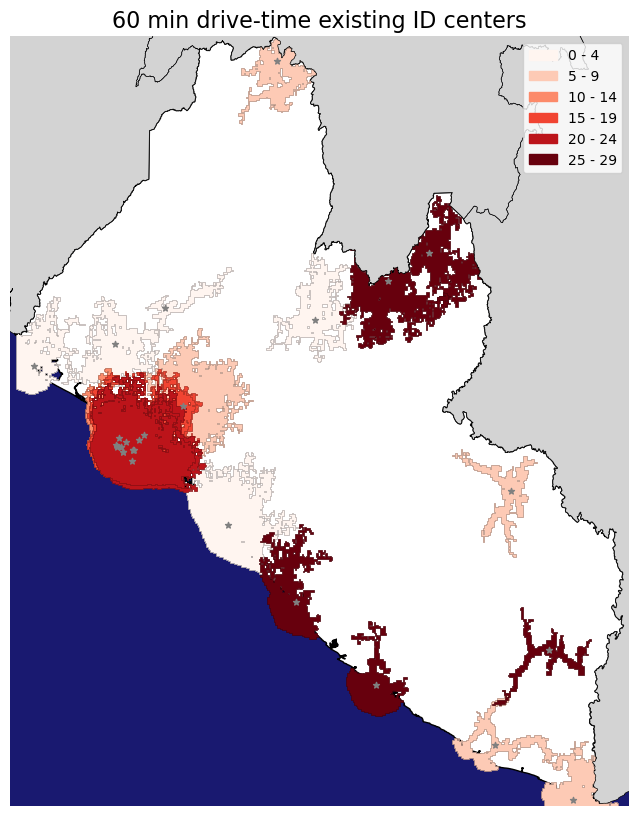

In [10]:
pd.set_option('mode.chained_assignment', None)
drive_vectors = gpd.read_file(os.path.join(results_folder, f"Drive_time_vectors_existing_ID.gpkg"))
plt, fig, ax = mapMisc.static_map_vector(drive_vectors.loc[drive_vectors['threshold'] == 60], "IDX", 
                                         #thresh = list(range(0, len(drive_vectors.loc[drive_vectors['threshold'] == 60]))),
                                         add_basemap=False, add_wb_borders_lines=False)
existing_sites.to_crs(in_pop.crs).plot(ax=ax, color='grey', markersize=20, marker="*")

bbox = in_pop.bounds
# plot ocean
ocean = gpd.GeoDataFrame(geometry=[box(*bbox).difference(lbr_country.to_crs(in_pop.crs).union_all())], crs=in_pop.crs)
ocean.plot(ax=ax, color="midnightblue", zorder=0)
lbr_country.to_crs(in_pop.crs).plot(ax=ax, facecolor="white", edgecolor="black", linewidth=1, zorder=0)
other_countries.to_crs(in_pop.crs).plot(ax=ax, facecolor="lightgrey", edgecolor="black", linewidth=0.5, zorder=1)


ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])
ax = ax.set_axis_off()
plt.title("60 min drive-time existing ID centers", fontsize=16)
plt.savefig("maps/LBR_tt_vector_existing_ID.png", dpi=300, bbox_inches='tight')
plt.show()


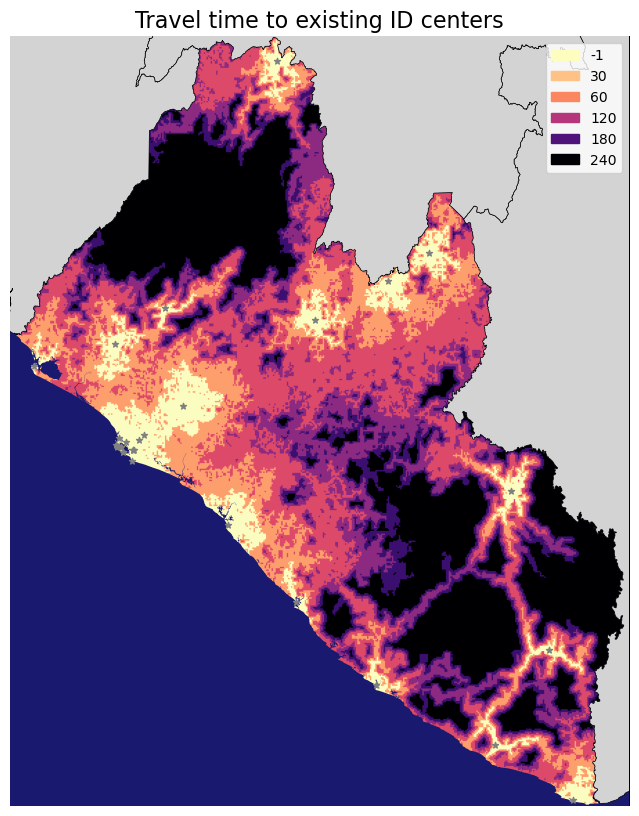

In [11]:
# Map tt to existing ID centers
tt_rast = rasterio.open(os.path.join(results_folder, f"Travel_time_to_existing_ID.tif"))
plt, fig, ax = mapMisc.static_map_raster(tt_rast, reverse_colormap=True, thresh=[-1,30,60,120,180,240])
existing_sites.to_crs(tt_rast.crs).plot(ax=ax, color='grey', markersize=20, marker="*")
other_countries.to_crs(tt_rast.crs).plot(ax=ax, facecolor="lightgrey", edgecolor="black", linewidth=0.5, zorder=1)
bbox = tt_rast.bounds
# plot ocean
ocean = gpd.GeoDataFrame(geometry=[box(*bbox).difference(lbr_country.to_crs(tt_rast.crs).union_all())], crs=tt_rast.crs)
ocean.plot(ax=ax, color="midnightblue", zorder=0)
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])
ax = ax.set_axis_off()
plt.title("Travel time to existing ID centers", fontsize=16)
plt.savefig("maps/LBR_tt_raster_existing_ID.png", dpi=300, bbox_inches='tight')
plt.show()

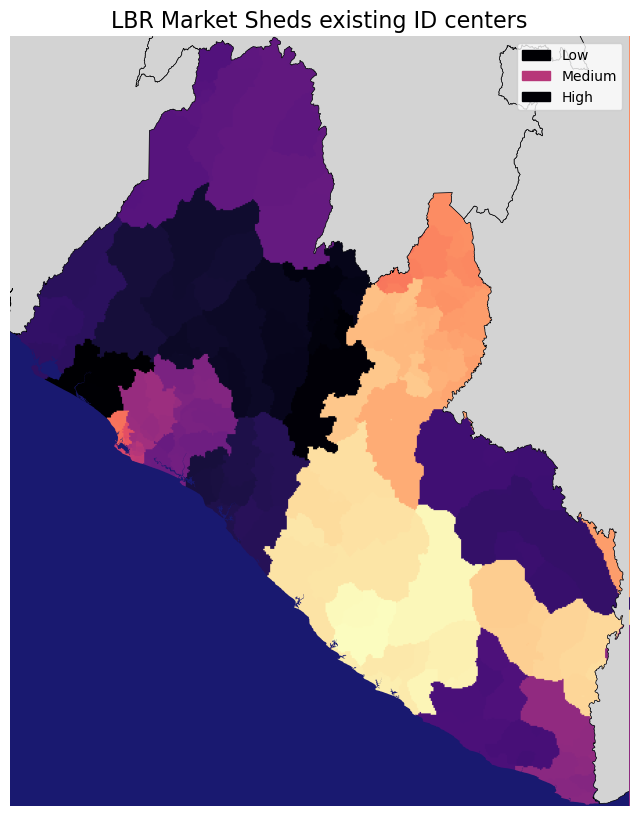

In [12]:
with rMisc.create_rasterio_inmemory(in_pop.meta, market_sheds) as marketsR:
    plt, fig, ax = mapMisc.static_map_raster(marketsR)

other_countries.to_crs(in_pop.crs).plot(ax=ax, facecolor="lightgrey", edgecolor="black", linewidth=0.5, zorder=1)
bbox = in_pop.bounds
# plot ocean
ocean = gpd.GeoDataFrame(geometry=[box(*bbox).difference(lbr_country.to_crs(in_pop.crs).union_all())], crs=in_pop.crs)
ocean.plot(ax=ax, color="midnightblue", zorder=0)
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])
ax = ax.set_axis_off()
plt.title("LBR Market Sheds existing ID centers", fontsize=16)
plt.savefig("maps/LBR_market_sheds_existing_ID.png", dpi=300, bbox_inches='tight')
plt.show()

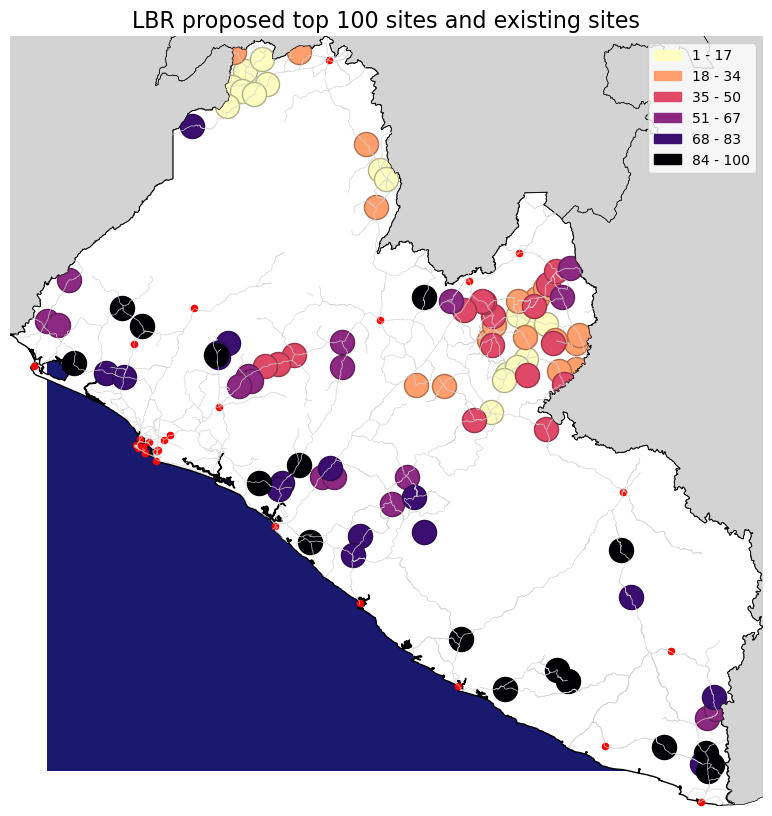

In [13]:
# Map proposed top 100 sites alonog with existing sites
top_100_sites = gpd.read_file(os.path.join(results_folder, "Top_100_proposed_ID_sites.gpkg"))
plt, fig, ax = mapMisc.static_map_vector(top_100_sites.to_crs(major_roads.crs), "rank", colormap='magma', reverse_colormap=True, add_basemap=False, add_wb_borders_lines=False)

major_roads.plot(ax=ax, color='lightgrey', linewidth=0.5)
lbr_country.plot(ax=ax, facecolor="white", edgecolor="black", linewidth=1, zorder=0)
other_countries.plot(ax=ax, facecolor="lightgrey", edgecolor="black", linewidth=0.5, zorder=1)
existing_sites.plot(ax=ax, color='red', markersize=20, marker="o")

bbox = lbr_country.total_bounds
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])
ax = ax.set_axis_off()
plt.title("LBR proposed top 100 sites and existing sites", fontsize=16)
plt.savefig("maps/LBR_proposed_top_100_and_existing_service_centers.png", dpi=300, bbox_inches='tight')
plt.show()

# Write summary to readme

## Existing licensing centers
1.	How many people within 60 mins and 120 mins drive time  
    a. Summarize at ADM1 and ADM2
2.	How many exclusive users within 120 mins drive time (Marketsheds)
3.	ADM1 and ADM2 summaries of population outside 120 min drive time of existing centers  
    a. This population layer is labelled “unserved population” and used for several analyses below
## Proposed centers
1.	Total # of people within 60, 120 min vectors  
    a. Replicate using the population layer from #3 above, which is the unserved population
2.	Marketsheds  
    a. Replicate using unserved population layer
3.	Prioritize proposed centers sequentially using the results of #1 and #2 to identify how to serve the most population with the fewest centers

In [14]:
# Write a README.md file summarizing the work so far
readme_file = "README.md"
with open(readme_file, 'w') as f:
    f.write("# Liberia ID centre travel time analysis\n")        
    f.write("This analysis evaluates travel time to existing and proposed ID centers in Liberia.\n")
    f.write("<img src='maps/LBR_existing_and_proposed_service_centers.png' alt='Map of primary roads and service centers' width='600'/>\n")
    f.write("\n")

    f.write("This was done using friction surface analysis to measure travel time to service centers, and map marketsheds for service centers\n")
    
    f.write("The following analysis were undertaken to quantify accessibility to ID centers in Liberia:\n")
    f.write("| Question | Output file |\n")
    f.write("|---|---|\n")
    f.write("| How many people are within 60 mins and 120 mins drive time to existing ID centers, summarized at ADM1 and ADM2 levels? | ADM2_tt_existing_ID.csv |\n")
    f.write("| How many exclusive users are within 120 mins drive time to existing ID centers (Marketsheds)? | Marketshed_population_existing_ID.csv |\n")
    f.write("| What is the population outside 120 min drive time of existing centers (unserved population)? | ADM2_tt_existing_ID.csv |\n")
    f.write("| How many people are within 60, 120 min drive time to proposed centers? | ADM2_tt_proposed_ID.csv |\n")
    f.write("| What are the Marketsheds for proposed centers? | Marketshed_population_proposed_ID.csv |\n")
    f.write("| How to prioritize proposed centers sequentially to serve the most population with the fewest centers? | Top_100_proposed_ID_sites.gpkg |\n")
    f.write("\n")

    f.write('## Maps of results\n')
    f.write("<img src='maps/LBR_tt_raster_existing_ID.png' alt='Travel time to existing ID centers map' width='600'/>\n")
    f.write("\n")
    f.write("The friction surface analysis measures travel time to the nearest destination from every location in the country, accounting for road networks and landcover-based travel speeds.\n\n")
    f.write("<img src='maps/LBR_tt_vector_existing_ID.png' alt='60 min drive-time existing ID centers' width='600'/>\n\n")
    f.write("Drive-time vectors show areas that can reach a service center within a given time threshold. This differs from the above analysis in that \
            each destination (ID centre) is treated independently, so the drive areas can overlap\n\n")
    f.write("<img src='maps/LBR_market_sheds_existing_ID.png' alt='LBR Market Sheds existing ID centers' width='600'/>\n\n")
    f.write("Marketsheds show the exclusive service area for each service center, i.e., the area that is closest to a given center compared to all other centers.\n")
    f.write("<img src='maps/LBR_proposed_top_100_and_existing_service_centers.png' alt='Map of proposed top 100 sites and existing sites' width='600'/>\n\n")
    f.write("The proposed top 100 sites are selected sequentially to maximize the unserved population within 60 mins drive time.\n")
    f.write("\n")
    
    
